In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [9]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download=True
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    transform=ToTensor(),
    download=True
)

In [35]:
classes = train_data.classes
print('Labels:')
print(classes)

Labels:
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor() Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


Shape of sample of train_data: torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Class: Ankle boot')

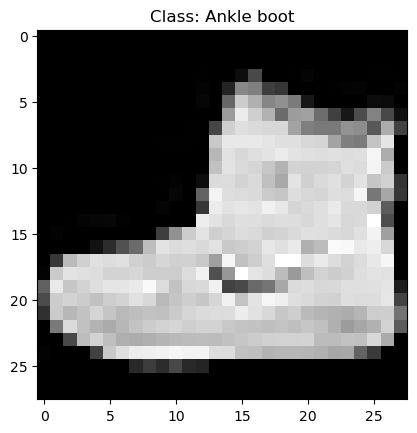

In [40]:
print(train_data, test_data)
print('\n')
image, label = train_data[0]
print(f'Shape of sample of train_data: {image.shape}')
plt.imshow(image.squeeze(), cmap='grey');
plt.title(f'Class: {classes[label]}')

In [41]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [45]:
# device agnostic code
device = None
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

device

'mps'

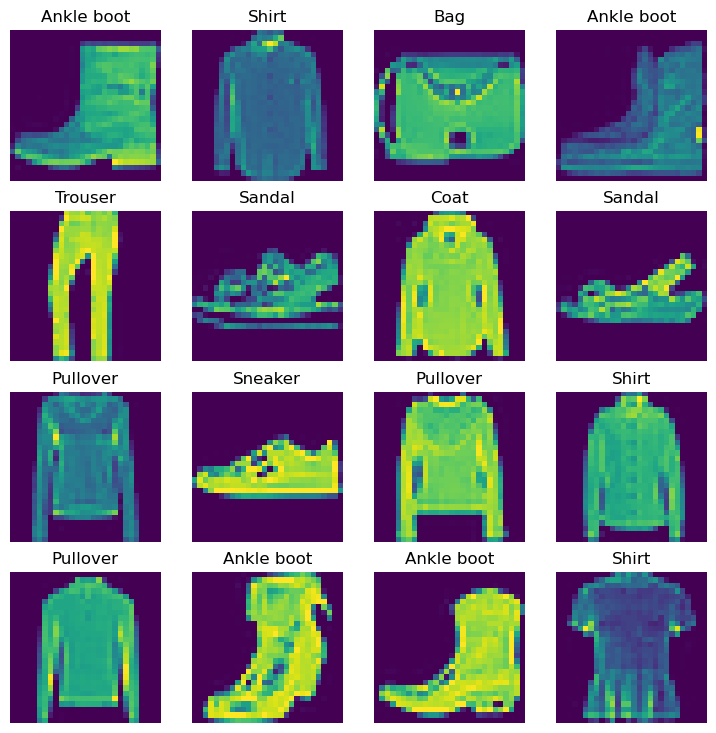

In [64]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    idx = torch.randint(low=0, high=len(train_data.data), size=(1,)).item()
    image, label = train_data[idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze())
    plt.title(classes[label])
    plt.axis(False)

In [79]:
BATCH_SIZE=32

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=True)

print(f'Size of Train Dataloader: {len(train_dataloader)}, with {BATCH_SIZE} samples each')
print(f'Size of Test Dataloader: {len(test_dataloader)}, with {BATCH_SIZE} samples each')

Size of Train Dataloader: 1875, with 32 samples each
Size of Test Dataloader: 313, with 32 samples each


In [104]:
images_batch, labels_batch = next(iter(train_dataloader))
images_batch.shape, labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Pullover')

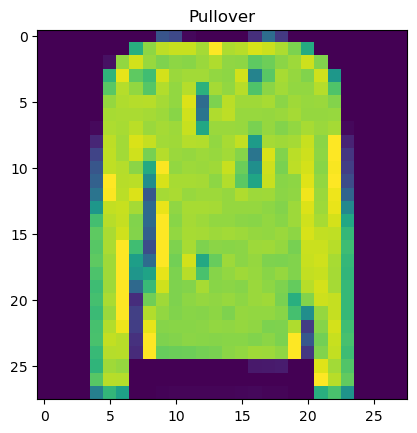

In [157]:
idx = torch.randint(low=0, high=len(images_batch), size=(1,)).item()
image, label = images_batch[idx], labels_batch[idx]
print(f'Image size: {image.shape}')
plt.imshow(image.squeeze());
plt.title(classes[label])

In [165]:
# Baseline Model

flatten_model = nn.Flatten()
print(f'Previous shape: {image.shape}, flattened shape: {flatten_model(image).shape}')

Previous shape: torch.Size([1, 28, 28]), flattened shape: torch.Size([1, 784])


In [166]:
class modelV0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)